In [2]:
import pandas as pd
import altair as alt

%matplotlib inline

# produce vector inline graphics
from IPython.display import set_matplotlib_formats, display, Markdown, HTML

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

set_matplotlib_formats('pdf', 'svg')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 4]
display(HTML("<style>.container { width:70% !important; }</style>"))

# From notebooks to apps with [Voilà](https://github.com/voila-dashboards/voila)

Today we'll be demoing [Voilà](https://github.com/voila-dashboards/voila), a library that turns Jupyter notebooks into standalone web applications. 


**Benefits of Voilà**
* By default, Voilà disallows execute requests from the front-end, preventing execution of arbitrary code.
* By default, Voilà runs with the strip_source option, which strips out the input cells from the rendered notebook.

## Why use Voilà? Let's consider some alternatives.

### Presenting a notebook on GitHub/GitLab/etc: no interactivity
* Ideal for collaboration with other data scientists, but we're talking about presenting results here
* Alright for sharing a quick, informal report, but that's about it. 
* **Use this when:**
    * A collaborator wants to glance over results quickly, as Binder/Streamlit/Voila take longer to start up.
        
### Sharing a notebook with Binder: *too much* interactivity
* Runs as a standard Jupyter notebook, so it's easy to play with code
* This can be intrusive or intimidating if you want to prototype a tool for a non-data scientist
* User can modify code... so they can break stuff!
* **Use this when:**
    * You want to link to an interactive example for using some software library
    * You're giving a demo like this one! 
    
### Creating a dashboard with Streamlit: *some* overhead
* More flexible and powerful than Jupyter and Voila
* Streamlit development workflow is disconnected from Jupyter workflow
* **Use this when:** 
    * you need to build a more powerful dashboard, but don't want/need to build a full web app.

### Creating a web application with Flask: lots of overhead
* **Use this when:** 
    * You project has specific, sophisiticated requirements, and the other tools won't cut it.
    * You want to prototype how you can embed ML in an existing app.



## Case study: Email clicks

### The problem / the user

We want to make an interactive report/dashboard for advertisement click-through rates on our website. This could just as easily be modified for something like email click rates, but that's the data we have.

We're planning on sending this to our marketing team, who have little to no experience writing code in Python or working with Jupyter notebooks. We don't want to make them install Jupyter, Conda, etc, and we don't want them to navigate big blocks of code. They just need info and visualizations. 

In the future, maybe we will want to build a more full-featured app using something like Streamlit, or start from scratch with Flask. For now, though, we want proof-of-concept and we want to iron out the project requirements. This means avoiding additional time spent on developing a web app, etc.

Our marketing team wants to know the following: **Who are our users? Which users are clicking on ads? Who would we be targeting?**

Our approach with be in providing some interactive visualizations and carrying out some rudimentary clustering. 

### Data
We'll be using an [example dataset](https://raw.githubusercontent.com/shubham13p/Ad-Click-Prediction/master/advertising.csv) found on GitHub. We'll use Pandas to load in this data and display the first few rows.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/shubham13p/Ad-Click-Prediction/master/advertising.csv')
df['Click_labeled'] = df['Clicked on Ad'].apply(lambda x: "Click" if x == 1 else "No Click")
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Click_labeled
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,No Click
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,No Click
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,No Click
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,No Click
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,No Click


## Density plots

Let's just take a look at the *density plots* of a few of these columns. These are like histograms, but smoothed. 

This gives us a quick view on distributions within our data. We see the following:

* Most users seem to be around 30 years old, but we have a pretty broad distribution overall .
* We see two "peaks" (or modes) in the daily usage features. This might mean we have two meaningful and distinct usage patterns.
* We'll be interested in age and usage as we continue our investigation of click rates.

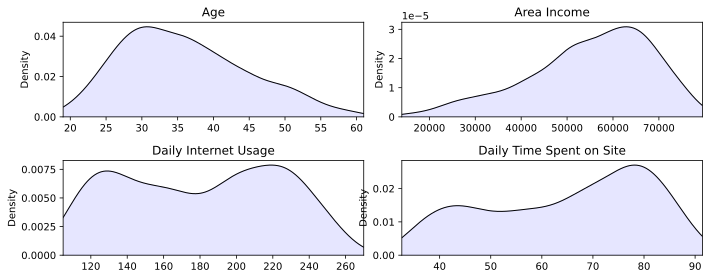

In [4]:
cols = ['Age', 'Area Income', 'Daily Internet Usage', 'Daily Time Spent on Site']

fig, axs = plt.subplots(2, 2)
for ix, col in enumerate(cols):
    row = ix // 2
    column =  ix % 2
    
    plt.tight_layout()
    
    ax = axs[row][column]
    
    
    df[[col]].plot.kde(title=col, 
                       legend=False, 
                       color='black',
                       ax = ax,
                       linewidth=1)
    
    ax.set_xlim(df[col].min(), df[col].max())
    ax.set_ylim(0)
    
    # Get the two lines from the axes to generate shading
    l1 = ax.lines[0]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax.fill_between(x1,y1, color="blue", alpha=0.1)

## Interactive plots with Altair


For more compelling and illuminating charts, we want to bring in some interactivity. 

For this, we'll use a package called [Altair](https://altair-viz.github.io/gallery/). There is no "best" visualization library, just different tools for different jobs. Here's a brief rundown of why I sometimes use Altair.

**Advantages of Altair**
* Quickly produce interactive, linked visualizations within Jupyter notebooks
* Easily transfer these visualizations to other web apps or contexts
* Interactivity runs client-side with JavaScript, so it works even on a static page (like in GitHub Pages)

**Disadvantages of Altair**
* Not very powerful or flexible as compared to things like Bokeh, Plotly, or D3
* Not as well-documented or developed as things like Matplotlib

### Temporal effects

In [5]:
bars = (alt.Chart(df, width=800, title='Click rate by month').mark_bar(width=100)
 .encode(
     alt.X('month(Timestamp):O', title=''),
     y=alt.Y('mean(Clicked on Ad):Q', title='', axis=alt.Axis(labels=False))
 ))
text = bars.mark_text(
    align='center',
    baseline='middle',
    dy=20,
    color='white',
    size=20
).encode(
    text=alt.Text('mean(Clicked on Ad):O', format=('.2f'))
)

(bars + text).configure_axis(labelAngle=0, labelFontSize=20).configure_title(fontSize=20)

alt.LayerChart(...)

## Age, time on site, click rate

Here, we're going to use a linked, interactive pair of charts to investigate how these three variables interact.

### What do we mean by "linked?"
* We can make a selection in each chart (try clicking and dragging).
* Notice how the selection in one chart modifies the data shown in the other.
* This is because both charts share a *view* on our underlying data.

### Why is this helpful?
* We want to communicate a multi-dimensional relationship here: there are distinct usage patterns by age, and we see that age and "time on site" both influence click rate. How is age tied to "time on site", though? An interactive chart makes it easy for the users to *find this out themselves*.

In [6]:
brush = alt.selection_interval(encodings=['x'], empty='all')
brush2 = alt.selection_interval(encodings=['x'], empty='all')

domain = ['No Click', 'Click']
range_ = ['lightgray', 'orange']

bars1 = alt.Chart(df).mark_bar().encode(
    x=alt.X('Daily Time Spent on Site:Q', bin=True),
    color='Click_labeled:N',
    y='count(Click_labeled):N'
).add_selection(
    brush
).transform_filter(
    brush2
).properties(
    title='Less time = More Clicks'
)

bars = alt.Chart(df).mark_bar().encode(
    x=alt.X('Age:Q', scale=alt.Scale(domain=(10, 65))),
    color=alt.Color('Click_labeled:N', scale=alt.Scale(domain=domain, range=range_)),
    y=alt.Y('count(Click_labeled):N', scale=alt.Scale(domain=(0, 62))),
).transform_filter(
    brush
).add_selection(
    brush2
).properties(
    title='Older = higher click rate'
)

(bars | bars1).configure_title(
    fontSize=20,
    anchor='start')

alt.HConcatChart(...)

### Another view on Age vs time on site

* Here, we make a stacked histogram of age and time on site. This communicates only *some* of the information in the charts above. Notably, we no longer tie this information to the click rate, which is the quantity we actually care about. 
* What do we conclude from this chart? What do these results actually **mean** with regards to the click rate? 
* We can somewhat observe that the younger groups increase at/around 70 minutes, but not as clearly as in the charts above.

In [7]:
bars = (alt.Chart(df).mark_bar()
 .encode(
     x=alt.X('Daily Time Spent on Site', bin=alt.Bin(maxbins=14)),
     y=alt.Y('count(Daily Time Spent on Site)', title=''),
     color=alt.Color('Age', 
                     scale=alt.Scale(scheme='viridis', reverse=True),
                     bin=alt.Bin(maxbins=10)))
 
 .properties(title='Over 70 minutes on site = younger users')
)


bars.configure_title(fontSize=20)

alt.Chart(...)

### Month and age

In [8]:
(alt.Chart(df, width=800, title='Age vs Month, Counts').mark_bar(width=100)
 .encode(
     alt.X('month(Timestamp):O', title=''),
     y=alt.Y('count(Clicked on Ad):Q', title='', axis=alt.Axis(labels=False)),
     color=alt.Color('Age', 
                         scale=alt.Scale(scheme='viridis', reverse=True),
                         bin=alt.Bin(maxbins=10))
 ).configure_axis(labelAngle=0, labelFontSize=20)).configure_title(fontSize=20)



alt.Chart(...)

## Topic Modeling

Here, we will try to get relevant topics from the ad text.

We'll use [Non-negative Matrix Factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) to split the ad text into 3 topics.



In [9]:
tfidf_vect = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
doc_term_matrix = tfidf_vect.fit_transform(df['Ad Topic Line'].values.astype('U'))

In [10]:
nmf = NMF(n_components=3, random_state=42)
nmf.fit(doc_term_matrix )

topic_values = nmf.transform(doc_term_matrix)
df['Topic'] = topic_values.argmax(axis=1)

In [11]:
nmf_components = nmf.components_
feature_names = tfidf_vect.get_feature_names()

divs = []

for i,topic in enumerate(nmf.components_):
    

    num_ads = len(df[df['Topic']==i])
    top_5 = [feature_names[i] for i in topic.argsort()[-5:]]  
    top = ''.join([f'* {word} \n' for word in  top_5])

    markdown = f'''<div style="width: 33%; float: left;"> 
    
### Topic #{i+1}

**Number of Ads in Topic:** {num_ads}

{top}

</div>
''' 
    
    divs.append(markdown)
    
display(Markdown(''.join(divs)))

<div style="width: 33%; float: left;"> 
    
### Topic #1

**Number of Ads in Topic:** 666

* customer 
* solution 
* based 
* oriented 
* focused 


</div>
<div style="width: 33%; float: left;"> 
    
### Topic #2

**Number of Ads in Topic:** 148

* structure 
* interface 
* user 
* state 
* multi 


</div>
<div style="width: 33%; float: left;"> 
    
### Topic #3

**Number of Ads in Topic:** 186

* configurable 
* desk 
* thinking 
* secured 
* line 


</div>


### Topics and click rate

In [12]:
base = (alt.Chart(df, width=400).mark_bar()
 .encode(
     x=alt.X('Topic:N', axis=alt.Axis(labelAngle=0,
                                        labelFontSize=16,
                                        titleFontSize=20,
                                        labelColor='gray',
                                        titleColor='gray')),
     y=alt.Y('mean(Clicked on Ad)', axis=alt.Axis(labels=False, title='')))
 
 .properties(title='No clear difference between topics and click rates'))


bars = base.encode(color=alt.Color('Topic:N', 
                         scale=alt.Scale(scheme='viridis', reverse=True)))

text = base.mark_text(
    align='center',
    baseline='middle',
    dy=20,
    color='white',
    size=24
).encode(
    text=alt.Text('mean(Clicked on Ad):O', format=('.2f'))
)

topic_age = (alt.Chart(df[df['Clicked on Ad']==True], width=400).mark_bar()
 .encode(
     x=alt.X('Age:Q', bin=True, axis=alt.Axis(labelAngle=0,
                                        labelFontSize=16,
                                        titleFontSize=20,
                                        labelColor='gray',
                                        titleColor='gray')),
     y=alt.Y('count()', axis=alt.Axis(labels=False, title='')),
     color=alt.Color('Topic:N', 
                         scale=alt.Scale(scheme='viridis', reverse=True)))
 
 .properties(title='Count of Ad Clicks by Topic and Age'))



((bars + text ) | topic_age).configure_title(fontSize=20)

alt.HConcatChart(...)